# IMPORT, CONFIG

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torchmetrics.functional import f1_score, recall, accuracy
from torchinfo import summary

import os
import random
import time
import re
from tqdm import tqdm
import pickle
import re
import gensim
import random
from collections import defaultdict
from collections import Counter
from textwrap import wrap

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

pd.set_option('display.max_rows', 500)

C:\Programs\miniconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.random.manual_seed(RANDOM_SEED)
torch.cuda.random.manual_seed_all(RANDOM_SEED)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
DEVICE

device(type='cuda')

# LOAD DATA

In [5]:
X = list()
with open('..\\datasets\\WOS\\WOS46985\\X.txt','r') as X_file:
    lines = X_file.readlines()
    for line in lines:
        X.append(line.strip())

In [6]:
Y = list()
with open('..\\datasets\\WOS\\WOS46985\\Y.txt','r') as Y_file:
    lines = Y_file.readlines()
    for line in lines:
        Y.append(line.strip())

In [7]:
YL1 = list()
with open('..\\datasets\\WOS\\WOS46985\\YL1.txt','r') as YL1_file:
    lines = YL1_file.readlines()
    for line in lines:
        YL1.append(line.strip())

In [8]:
YL2 = list()
with open('..\\datasets\\WOS\\WOS46985\\YL2.txt','r') as YL2_file:
    lines = YL2_file.readlines()
    for line in lines:
        YL2.append(line.strip())

In [19]:
source = pd.DataFrame({'texts':pd.Series(X, dtype='object').apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x)),
 #'tokens':pd.Series(tokens, dtype='object'),
 'Y':pd.Series(Y, dtype='float'),
 'YL1':pd.Series(YL1, dtype='float'),
 'YL2':pd.Series(YL2, dtype='float')})
source = source.astype({'Y': int, 'YL1': int, 'YL2':int})

In [20]:
source.head(20)

,texts,Y,YL1,YL2
0,2 1dimensional nonlinear optical waves throug...,12,0,12
1,betaamyloid A beta and tau pathology become in...,74,5,2
2,Decreasing of energy consumption and environme...,68,4,7
3,Hybrid electric vehicles are assumed to play a...,26,1,10
4,L34Dihydroxyphenylalanine LDOPA remains the pr...,115,5,43
5,Objective In order to increase classification ...,0,0,0
6,Recent advances in deep brain stimulators and ...,125,6,0
7,This paper presents the concept of a softwared...,27,1,10
8,We develop a generalised unsteady plume theory...,56,3,4
9,while ghrelin cells were the most numerous du...,46,2,13


In [21]:
source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46985 entries, 0 to 46984
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   46985 non-null  object
 1   Y       46985 non-null  int32 
 2   YL1     46985 non-null  int32 
 3   YL2     46985 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 917.8+ KB


source.groupby(by=['YL1','YL2']).count().reset_index()

print(source[['YL1','YL2']].groupby(by=['YL1','YL2']).count().reset_index().groupby('YL1').count().reset_index())
print('sum_col: ',source[['YL1','YL2']].groupby(by=['YL1','YL2']).count().reset_index().groupby('YL1').count().reset_index().YL2.sum())

len(source.Y.value_counts())

In [22]:
del X, Y, YL1, YL2 #,tokens

In [13]:
target_column = 'YL1'
data = source[['texts',target_column]] # source source[source['YL1']==0]

In [14]:
data

,texts,Y
0,2 1dimensional nonlinear optical waves throug...,12
1,betaamyloid A beta and tau pathology become in...,74
2,Decreasing of energy consumption and environme...,68
3,Hybrid electric vehicles are assumed to play a...,26
4,L34Dihydroxyphenylalanine LDOPA remains the pr...,115
...,...,...
46980,Zusammenfassung Hintergrund Karate erfreut sic...,122
46981,ZWave is an implementation of home automation ...,15
46982,Zwitterionic peptides were anchored to a condu...,110
46983,ZY3 has been acquiring high quality imagery si...,10


In [15]:
train_df, test_df = train_test_split(data, test_size=0.33, random_state=RANDOM_SEED,stratify=data[target_column].to_list())

In [16]:
len(train_df), len(test_df)

(31479, 15506)

# PREPROCESSING

We initialize word vectors with the publicly available
word2vec vectors that are pre-trained using
about 100B words from the Google News Dataset.
The dimensionality of the word vectors is 300. We
also initialize the word vector for the unknown
words from the uniform distribution [-0.25, 0.25].
We then fine-tune the word vectors along with other
model parameters during training.

In [17]:
EMBEDDING_SIZE = 300

In [18]:
Word2Vec = gensim.models.KeyedVectors.load_word2vec_format('./test_models/GoogleNews-vectors-negative300.bin', binary=True)  

In [19]:
class MyTokenizer():
    class Encoding:
        def __init__(self):
            super().__init__()
            tokens = list()
            ids = list()

    def __init__(self):
        self.index2token = list()
        self.token2index = dict()
        self.token2count = Counter()
        self.encoding = MyTokenizer.Encoding()
        self.reset()

    def add_sentence(self, sentence):
        for token in self.encode(sentence).tokens:
            self.add_token(token)

    def add_token(self, token):
        if token not in self.token2index:
            self.token2index[token] = len(self.index2token)
            self.token2count[token] += 1
            self.index2token.append(token)
        else:
            self.token2count[token] += 1
    
    def has_token(self, token) -> bool:
        return token in self.token2index

    def add_texts(self):
        sents_texts = train_df.texts.to_list()
        for sent in sents_texts:
            self.add_sentence(sent)

    def token_to_id(self, token):
        if token in self.token2index:
            return self.token2index[token]
        return self.token2index["<unk>"]

    def id_to_token(self, id_):
        if id_ in self.index2token:
            return self.index2token[id_]
        print('Нет такого id в словаре!')
    
    def is_empty(self):
        empty_size = 4
        return self.size() <= empty_size

    def shrink(self, n):
        # для сокращения словаря (выбирает n самых частых слов) (подаётся n)
        best_tokens = self.token2count.most_common(n)
        self.reset()
        for token, count in best_tokens:
            self.add_token(token)
            self.token2count[token] = count

    def reset(self):
        self.token2count = Counter()
        self.index2token = ["<PAD>", "<UNK>"]
        self.token2index = {token: index for index, token in enumerate(self.index2token)}

    def get_vocab(self):
        return self.token2index
    
    def get_vocab_size(self):
        return len(self.index2token)
        
    def encode(self, text: str): # sentence: str, max_length: int
        text = text.lower().strip()
        self.encoding.tokens = text.split(' ')
        self.encoding.tokens = [token.replace('.','').replace(',','') for token in self.encoding.tokens]
        return self.encoding

    def decode(self, ids: torch.LongTensor):
        return print([self.index2token[id_] for id_ in ids].join(' '))

In [20]:
tokenizer = MyTokenizer()

In [21]:
tokenizer.add_texts()
#tokenizer.shrink(10000)

In [22]:
tokenizer.token2index

{'<PAD>': 0,
 '<UNK>': 1,
 'one': 2,
 'of': 3,
 'the': 4,
 'important': 5,
 'prerequisites': 6,
 'for': 7,
 'efficient': 8,
 'design': 9,
 'optimization': 10,
 'microwave': 11,
 'structures': 12,
 'is': 13,
 'availability': 14,
 'fast': 15,
 'yet': 16,
 'reliable': 17,
 'replacement': 18,
 'models': 19,
 'surrogates': 20,
 'so': 21,
 'that': 22,
 'multiple': 23,
 'evaluations': 24,
 'structure': 25,
 'at': 26,
 'hand': 27,
 'can': 28,
 'be': 29,
 'executed': 30,
 'in': 31,
 'reasonable': 32,
 'timeframe': 33,
 'direct': 34,
 'utilization': 35,
 'fullwave': 36,
 'electromagnetic': 37,
 'em': 38,
 'simulations': 39,
 'handling': 40,
 'optimizationrelated': 41,
 'tasks': 42,
 'often': 43,
 'prohibitive': 44,
 'a': 45,
 'popular': 46,
 'approach': 47,
 'to': 48,
 'construction': 49,
 'datadriven': 50,
 'modeling': 51,
 'unfortunately': 52,
 'it': 53,
 'normally': 54,
 'requires': 55,
 'large': 56,
 'number': 57,
 'training': 58,
 'samples': 59,
 'and': 60,
 'virtually': 61,
 'infeasible': 

In [23]:
tokenizer.index2token

['<PAD>',
 '<UNK>',
 'one',
 'of',
 'the',
 'important',
 'prerequisites',
 'for',
 'efficient',
 'design',
 'optimization',
 'microwave',
 'structures',
 'is',
 'availability',
 'fast',
 'yet',
 'reliable',
 'replacement',
 'models',
 'surrogates',
 'so',
 'that',
 'multiple',
 'evaluations',
 'structure',
 'at',
 'hand',
 'can',
 'be',
 'executed',
 'in',
 'reasonable',
 'timeframe',
 'direct',
 'utilization',
 'fullwave',
 'electromagnetic',
 'em',
 'simulations',
 'handling',
 'optimizationrelated',
 'tasks',
 'often',
 'prohibitive',
 'a',
 'popular',
 'approach',
 'to',
 'construction',
 'datadriven',
 'modeling',
 'unfortunately',
 'it',
 'normally',
 'requires',
 'large',
 'number',
 'training',
 'samples',
 'and',
 'virtually',
 'infeasible',
 'exhibit',
 'highly',
 'nonlinear',
 'responses',
 'eg',
 'filters',
 'or',
 'couplers',
 'this',
 'work',
 'designoriented',
 'technique',
 'proposed',
 'where',
 'good',
 'accuracy',
 'achieved',
 'by',
 'careful',
 'nonuniform',
 'spa

In [24]:
tokenizer.token2count

Counter({'one': 6448,
         'of': 252987,
         'the': 346594,
         'important': 4990,
         'prerequisites': 13,
         'for': 65622,
         'efficient': 1576,
         'design': 6653,
         'optimization': 1517,
         'microwave': 134,
         'structures': 1760,
         'is': 60117,
         'availability': 521,
         'fast': 703,
         'yet': 1055,
         'reliable': 662,
         'replacement': 411,
         'models': 4284,
         'surrogates': 18,
         'so': 1493,
         'that': 45379,
         'multiple': 2796,
         'evaluations': 311,
         'structure': 2844,
         'at': 17687,
         'hand': 755,
         'can': 13329,
         'be': 22683,
         'executed': 113,
         'in': 154981,
         'reasonable': 196,
         'timeframe': 11,
         'direct': 1277,
         'utilization': 565,
         'fullwave': 25,
         'electromagnetic': 325,
         'em': 119,
         'simulations': 988,
         'handling': 223,

In [25]:
tokenizer.get_vocab_size()

157995

In [26]:
embedding_matrix = torch.zeros((len(tokenizer.index2token), EMBEDDING_SIZE))
embedding_matrix.shape

torch.Size([157995, 300])

In [27]:
for index, word in zip(tokenizer.token2index.values(),tokenizer.token2index.keys()):
    try:
        embedding_matrix[index] = torch.from_numpy(Word2Vec.get_vector(word).copy())
    except:
        embedding_matrix[index] = (-0.25 - 0.25) * torch.rand(EMBEDDING_SIZE) + 0.25

In [28]:
embedding_matrix[tokenizer.token2index['<PAD>']] = torch.zeros(EMBEDDING_SIZE)

In [29]:
embedding_matrix[tokenizer.token2index['<UNK>']] = (-0.25 - 0.25) * torch.rand(EMBEDDING_SIZE) + 0.25

In [30]:
VOCAB_SIZE = tokenizer.get_vocab_size()
VOCAB_SIZE

157995

In [31]:
del Word2Vec

# DATASET

First, we usemaxlen to denote the maximum length
of the sentence in the training set. As the convolution
layer in our model requires fixed-length input,
we pad each sentence that has a length less
than maxlen with special symbols at the end that
indicate the unknown words. For a sentence in the
test dataset, we pad sentences that are shorter than
maxlen in the same way, but for sentences that
have a length longer than maxlen, we simply cut
extra words at the end of these sentences to reach
maxlen.

In [32]:
# MAX_LEN = train_df['texts'].apply(lambda x: len(tokenizer.encode(x).tokens)).max()
# MAX_LEN

In [33]:
class WOSDataset(Dataset):

    def __init__(self, dataset, tokenizer, device):
        self.dataset = dataset['texts'].values
        self.token2index = tokenizer.token2index
        self.length = dataset.shape[0]
        self.target = dataset[target_column].values # !!!
        self.device = device

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        ids = []
        for token in tokenizer.encode(self.dataset[index]).tokens:
            if token in self.token2index:
                ids.append(self.token2index[token])
            else:
                ids.append(self.token2index['<UNK>'])
        y = self.target[index]
        return ids, y    

    
    def collate_fn(self, batch):
        input_ids, y = list(zip(*batch)) # zip делает кортёжи соотв. эл-в и они записываются в list
        MAX_LEN_BATCH = max(map(len,input_ids))
        padded_ids = torch.empty((len(batch), MAX_LEN_BATCH), dtype=torch.long)
        for idx, ids in enumerate(input_ids):
            to_pad = MAX_LEN_BATCH - len(ids)
            padded_ids[idx] = torch.cat((torch.LongTensor(ids), torch.zeros(to_pad)))
        padded_ids = padded_ids.to(self.device)
        labels = torch.LongTensor(y).to(self.device)
        return padded_ids, labels  

#     def collate_fn(self, batch):
#         input_ids, y = list(zip(*batch)) # zip делает кортёжи соотв. эл-в и они записываются в list
#         padded_ids = torch.empty((len(batch), MAX_LEN), dtype=torch.long)
#         for idx, ids in enumerate(input_ids):
#             if len(ids) <= MAX_LEN:
#                 to_pad = MAX_LEN - len(ids)
#                 padded_ids[idx] = torch.cat((torch.LongTensor(ids), torch.zeros(to_pad)))
#             else:
#                 padded_ids[idx] = torch.LongTensor(ids[:MAX_LEN])
#         padded_ids = padded_ids.to(self.device)
#         labels = torch.LongTensor(y).to(self.device)
#         return padded_ids, labels

In [34]:
BATCH_SIZE = 512

In [35]:
train_dataset = WOSDataset(train_df, tokenizer, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=BATCH_SIZE)

In [36]:
test_dataset = WOSDataset(test_df, tokenizer, DEVICE)
test_sampler = SequentialSampler(test_dataset)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, sampler=test_sampler, batch_size=BATCH_SIZE)

# Model

1) dp=0.5 1conv (without stride) out_lin filter=150 rnn=150 ks=3 (with weightloss) --

2) dp=0 1conv (without stride) out_lin filter=150 rnn=150 ks=3 (with weightloss) --

3) dp=0 1conv (stride=ks) out_lin filter=150 rnn=150 ks=3 (with weightloss) epoch20 0.707704822486

4) dp_emb=0.5 1conv (stride=ks) out_lin filter=150 rnn=150 ks=3 (with weightloss) epoch30 0.7401465509012451

#### Broadly speaking, to reduce overfitting, you can:
#### increase regularization
#### reduce model complexity
#### perform early stopping
#### increase training data

For regularization, we employ two commonly used
techniques: dropout (Hinton et al., 2012) and L2
weight regularization. We apply dropout to prevent
co-adaptation. In our model, we either apply
dropout to word vectors before feeding the sequence
of words into the convolutional layer or to the output
of LSTM before the softmax layer. The L2 regularization
is applied to the weight of the softmax layer.

For SST, the number of filters of length 3 is set to
be 150 and the memory dimension of LSTM is set
to be 150, too. The word vector layer and the LSTM
layer are dropped out with a probability of 0.5.

We also add L2 regularization
with a factor of 0.001 to the weights in the softmax
layer for both tasks.

For text classification, we regard the output of the
hidden state at the last time step of LSTM as the
document representation and we add a softmax layer
on top. We train the entire model by minimizing
the cross-entropy error.

We employ stochastic
gradient descent (SGD) to learn the model
parameters and adopt the optimizer RMSprop.

In [37]:
#import gc
#del model
#torch.cuda.empty_cache()
#gc.collect()

In [38]:
embedding_matrix

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0475,  0.1171,  0.0149,  ...,  0.2283, -0.1562, -0.1946],
        [ 0.0457, -0.1455,  0.1562,  ..., -0.0159,  0.0067, -0.0019],
        ...,
        [ 0.0352, -0.0845, -0.1504,  ..., -0.0664,  0.1553,  0.0679],
        [-0.1414,  0.2037, -0.2315,  ..., -0.0063, -0.1475, -0.1672],
        [-0.1033,  0.1558,  0.1945,  ...,  0.2409,  0.2243, -0.0317]])

In [39]:
class C_LSTM(nn.Module): # делаем свёртки на векторах
    def __init__(self, vocab_size, embed_size, hidden_size_cnn, kernel_size, stride, hidden_size_rnn, num_classes): # может быть словосочетания из 3 слов содержат достаточную информацию для классификации текста (например, по токсичности (3 слова грубых))
        super().__init__()

        self.embeddings = nn.Embedding.from_pretrained(embedding_matrix,freeze=False,padding_idx=0)
        #self.embeddings = nn.Embedding(vocab_size, embed_size, 0)

        self.cnn1 = nn.Conv1d(embed_size, hidden_size_cnn, kernel_size, stride) # (на выходе batch_size x hiden_size x seq_le1) (размерность ядра - embed_size x kernel_size)

        self.rnn = nn.LSTM(input_size=hidden_size_cnn, hidden_size=hidden_size_rnn, batch_first=True)
        
        self.linear = nn.Linear(hidden_size_rnn, num_classes)

        self.dropout = nn.Dropout(0.5)

        self.softmax = nn.Softmax(-1)

    def forward(self, inp): # (batch_size, seq_len)
#         print('inp.shape',inp.shape)
        emb = self.embeddings(inp)  # (batch_size, seq_len, embed_size)
#         print('emb.shape',emb.shape)
        emb_perm = emb.permute(0, 2, 1) # (batch_size, embed_size, seq_len)
#         print('emb_perm.shape',emb_perm.shape)
        emb_perm_dp = self.dropout(emb_perm) # (batch_size, embed_size, seq_len)
#         print('emb_perm_dp.shape',emb_perm_dp.shape)
        emb_cnn = F.relu(self.cnn1(emb_perm_dp)) # (batch_size, embed_size, seq_len*) (N,C_in,L_in) -> (N,C_out,L_out)
#         print('emb_cnn3.shape',emb_cnn3.shape)
        emb_cnn_perm = emb_cnn.permute(0, 2, 1) # (batch_size, seq_len*, embed_size)
#         print('emb_cnn_perm.shape',emb_cnn_perm.shape)
        output_rnn, (hidden_rnn, cell_rnn) = self.rnn(emb_cnn_perm)
        # (N,L,H_in) -> (N,L,H_out), ((1,N,H), (1,N,H_cell))
        #  (batch_size, seq_len*,hidden_size_rnn), ((1, batch_size, hidden_size_rnn), (1, batch_size, hidden_size_rnn))
#         print('output_rnn.shape',output_rnn.shape)
#         print('hidden_rnn.shape',hidden_rnn.shape)
#         print('cell_rnn.shape',cell_rnn.shape)
#         emb_rnn_dp = self.dropout(hidden_rnn.squeeze(0)) # (batch_size, hidden_size_rnn)
#         print('emb_rnn_dp.shape',emb_rnn_dp.shape)
        out_lin = self.linear(hidden_rnn.squeeze(0)) # (batch_size, num_classes)
#         print('out_lin.shape',out_lin.shape)
#         print('-'*20)
        #pred = self.softmax(out_lin) # (batch_size, num_classes)
        #print('pred',pred)
        return out_lin
    
    def compute_l2_loss(self, w):
        return torch.square(w).sum()

In [40]:
KERNEL_SIZE = 3
STRIDE = 3
HIDDEN_SIZE_CNN = 150
HIDDEN_SIZE_RNN = 150
L2_FACTOR = 0.001
NUM_CLASSES = len(set(data[target_column].values))

In [41]:
NUM_EPOCHS = 40

In [42]:
model = C_LSTM(VOCAB_SIZE,EMBEDDING_SIZE, HIDDEN_SIZE_CNN, KERNEL_SIZE, STRIDE, HIDDEN_SIZE_RNN, NUM_CLASSES)
#optimizer = optim.RMSprop(model.parameters())
optimizer = optim.Adam(model.parameters(), lr=0.005)
weight_loss = torch.FloatTensor(1-(train_df.groupby(target_column)[target_column].count()/len(train_df)).values)
criterion = nn.CrossEntropyLoss(weight=weight_loss)

In [43]:
summary(model)

Layer (type:depth-idx)                   Param #
C_LSTM                                   --
├─Embedding: 1-1                         47,398,500
├─Conv1d: 1-2                            135,150
├─LSTM: 1-3                              181,200
├─Linear: 1-4                            20,234
├─Dropout: 1-5                           --
├─Softmax: 1-6                           --
Total params: 47,735,084
Trainable params: 47,735,084
Non-trainable params: 0

In [44]:
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

# TRAIN

In [45]:
train_losses = []
train_f1s = []
test_losses = []
test_f1s = []

best_f1 = 0

model_parameters = tuple(model.parameters())

for e in range(NUM_EPOCHS):
    train_epoch_loss = 0
    train_epoch_metric = 0
    model.train()
    print(f'\nstarting Epoch {e}')
    print('Training...')
    for i, (texts, labels) in enumerate(train_iterator):
        optimizer.zero_grad()
        prediction = model(texts)
        #print('pred',prediction.argmax(-1))
        #print('labels',labels)
        loss = criterion(prediction, labels)
        
        l2_parameters = [model_parameters[-2].view(-1), model_parameters[-1].view(-1)] # linear_weight, linear_bias
        loss += L2_FACTOR * model.compute_l2_loss(torch.cat(l2_parameters))
        
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        train_batch_metric = f1_score(prediction.long().detach().cpu().argmax(-1), labels.long().detach().cpu(), average='macro')
        train_epoch_metric += train_batch_metric
        if not (i + 1) % int(len(train_iterator)/5):
            print(f'Train loss: {train_epoch_loss/(i+1)}, Train f1: {train_epoch_metric/(i+1)}')

    train_f1, train_loss = train_epoch_metric / len(train_iterator), train_epoch_loss / len(train_iterator)
    train_losses.append(train_loss)
    train_f1s.append(train_f1)
    
    print('\nEvaluating on test...')
    test_epoch_loss = 0
    test_epoch_metric = 0
    model.eval()
    with torch.no_grad():
        for i, (texts, labels) in enumerate(test_iterator): 
            optimizer.zero_grad()
            prediction = model(texts)
            loss = criterion(prediction, labels)
            test_epoch_loss += loss.item()
            test_batch_metric = f1_score(prediction.argmax(-1).long().detach().cpu(), labels.long().detach().cpu(),average='macro')
            test_epoch_metric += test_batch_metric

            if not (i + 1) % int(len(test_iterator)/5):
                print(f'test loss: {test_epoch_loss/(i+1)}, test f1: {test_epoch_metric/(i+1)}')  

    test_f1, test_loss = test_epoch_metric / len(test_iterator), test_epoch_loss / len(test_iterator)
    test_losses.append(test_loss)
    test_f1s.append(test_f1)

    if test_f1 > best_f1:
        best_f1 = test_f1
        torch.save(
            model.state_dict(), "BEST_C-LSTM_WOS.pt"
        )


starting Epoch 0
Training...
Train loss: 4.899692336718242, Train f1: 0.00015967732487979838
Train loss: 4.8854228258132935, Train f1: 0.0001589585973781241
Train loss: 4.874874830245972, Train f1: 0.00015094446989330663
Train loss: 4.870179881652196, Train f1: 0.00014874427440752955
Train loss: 4.865287709236145, Train f1: 0.0001459809150255806

Evaluating on test...
test loss: 4.836295207341512, test f1: 0.00020907403765588453
test loss: 4.835310419400533, test f1: 0.0002466083244725809
test loss: 4.83871865272522, test f1: 0.00022645583683176632
test loss: 4.836143930753072, test f1: 0.00023437048169876155
test loss: 4.835088539123535, test f1: 0.00024666511262844674

starting Epoch 1
Training...
Train loss: 4.844712495803833, Train f1: 0.00040688721757947455
Train loss: 4.845360438028972, Train f1: 0.00027883430936493986
Train loss: 4.847046004401313, Train f1: 0.0002314226395195481
Train loss: 4.848357250293096, Train f1: 0.0002018769592549133
Train loss: 4.847132976849874, Train

Train loss: 3.570647041002909, Train f1: 0.029102218287094042
Train loss: 3.5749478240807853, Train f1: 0.029998961245061087
Train loss: 3.57699168920517, Train f1: 0.029998010128242145

Evaluating on test...
test loss: 3.6142945289611816, test f1: 0.03101051649818093
test loss: 3.6097424228986106, test f1: 0.032163559302684906
test loss: 3.6099319722917347, test f1: 0.03332171975497773
test loss: 3.620615233977636, test f1: 0.032817260871365356
test loss: 3.625189749399821, test f1: 0.03230298447795446

starting Epoch 13
Training...
Train loss: 3.491789082686106, Train f1: 0.03824667807235103
Train loss: 3.4963254034519196, Train f1: 0.03864972535763045
Train loss: 3.492949194378323, Train f1: 0.03833971074041906
Train loss: 3.4853585908810296, Train f1: 0.039987950901838314
Train loss: 3.487854365507762, Train f1: 0.040482403518128283

Evaluating on test...
test loss: 3.5531087716420493, test f1: 0.04354781216834206
test loss: 3.552532414595286, test f1: 0.04152254084542154
test loss

test loss: 3.3365846342510648, test f1: 0.09792044845590511
test loss: 3.3470598558584848, test f1: 0.0965986336901119
test loss: 3.348061974843343, test f1: 0.09559542776207987

starting Epoch 25
Training...
Train loss: 2.7568913300832114, Train f1: 0.15716636972262066
Train loss: 2.7734413842360177, Train f1: 0.15485039820938534
Train loss: 2.792726046509213, Train f1: 0.15317561201266952
Train loss: 2.7932621190945306, Train f1: 0.15250240617833669
Train loss: 2.791758068402608, Train f1: 0.152185484349234

Evaluating on test...
test loss: 3.374944011370341, test f1: 0.09985654829723294
test loss: 3.362653652826945, test f1: 0.09755262744485454
test loss: 3.3384043508105807, test f1: 0.09679301044088273
test loss: 3.3465770880381265, test f1: 0.09647389702545511
test loss: 3.352461822827657, test f1: 0.0959792698271694

starting Epoch 26
Training...
Train loss: 2.724293887615204, Train f1: 0.154565346867701
Train loss: 2.7235940297444663, Train f1: 0.16013202171820412
Train loss: 2.

Train loss: 2.3860764702161155, Train f1: 0.23378227835029974
Train loss: 2.392877623438835, Train f1: 0.23529395425901542
Train loss: 2.3967639327049257, Train f1: 0.23475790584915035

Evaluating on test...
test loss: 3.1756163438161216, test f1: 0.14977419596556388
test loss: 3.19221431016922, test f1: 0.14558731999863808
test loss: 3.1647720204459295, test f1: 0.14355278714752914
test loss: 3.183322628339132, test f1: 0.14166003980341277
test loss: 3.1858897765477496, test f1: 0.14323440255243666

starting Epoch 38
Training...
Train loss: 2.34713743130366, Train f1: 0.24024265073377216
Train loss: 2.3360149363676705, Train f1: 0.24563389319091064
Train loss: 2.3407834238476224, Train f1: 0.2460075439246612
Train loss: 2.3433524866898856, Train f1: 0.24645333969878658
Train loss: 2.3348012646039327, Train f1: 0.24792991307005197

Evaluating on test...
test loss: 3.207744598388672, test f1: 0.1500967223955971
test loss: 3.1976044376691184, test f1: 0.14758314806789558
test loss: 3.168

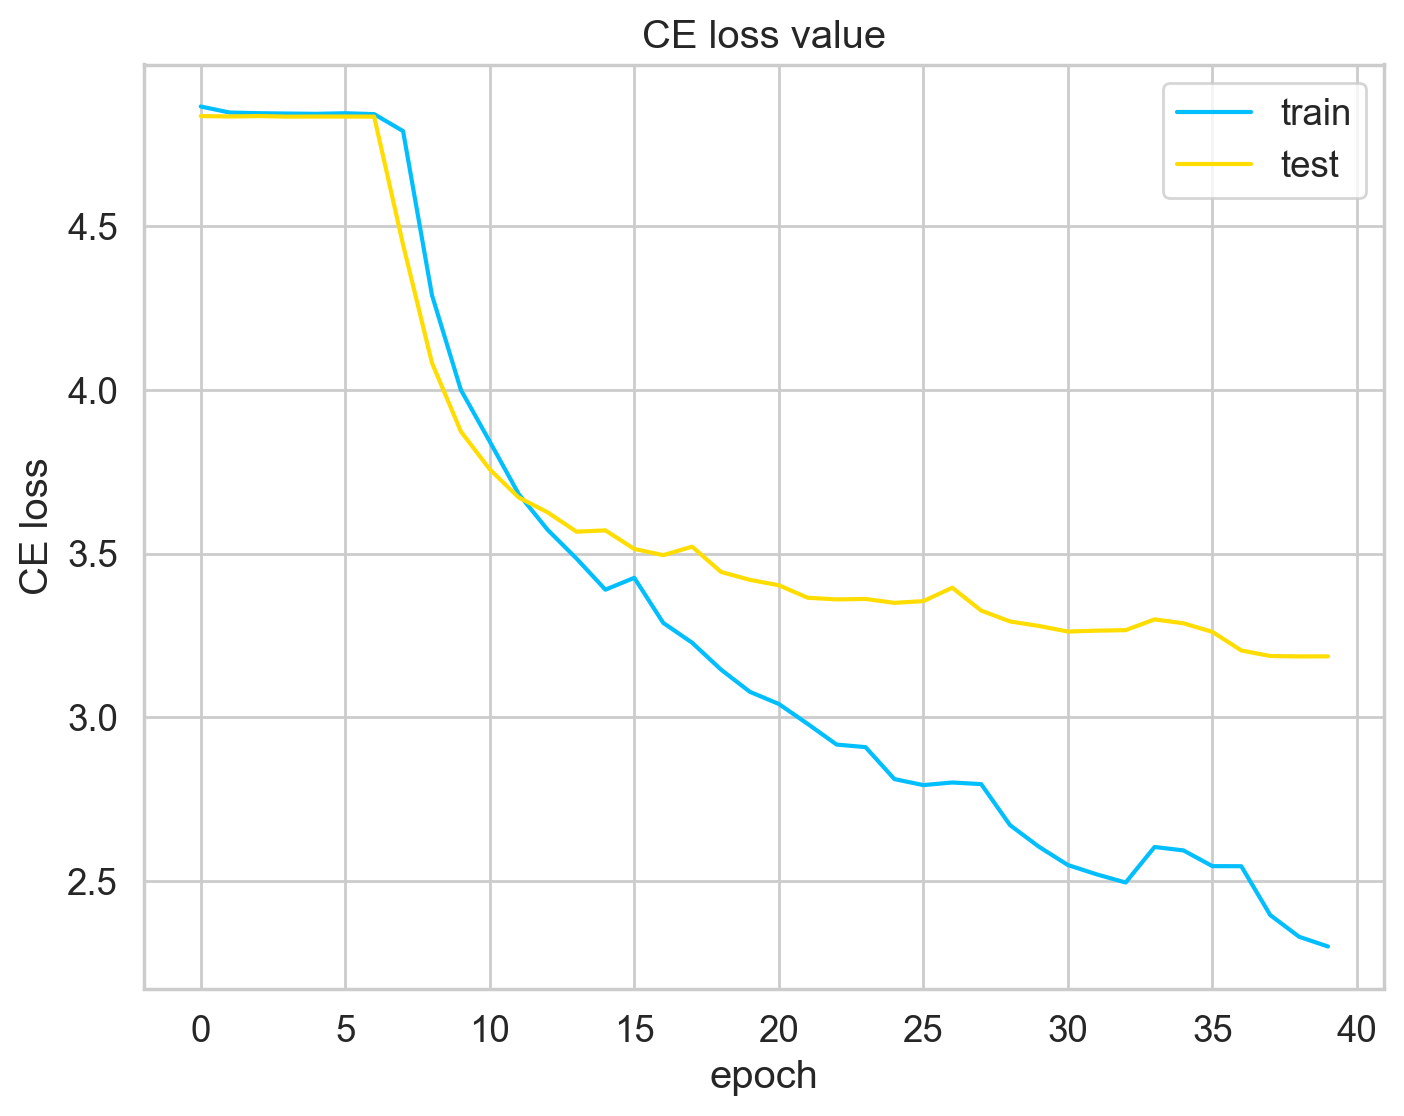

In [46]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('CE loss value')
plt.ylabel('CE loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

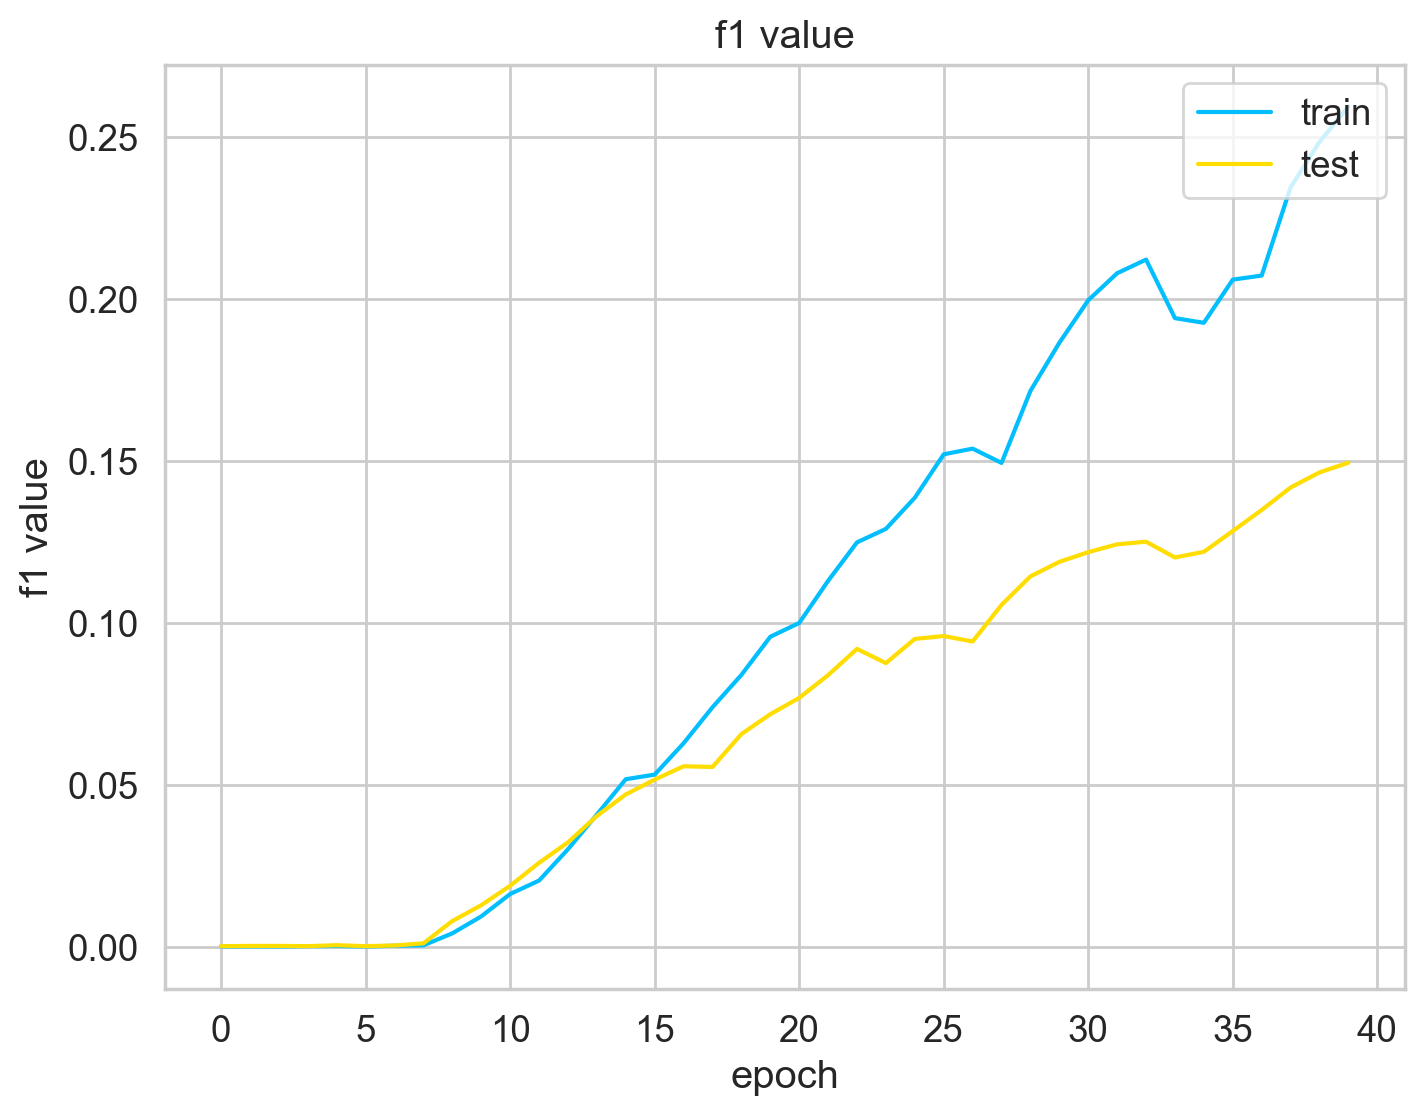

In [47]:
import matplotlib.pyplot as plt
plt.plot(train_f1s)
plt.plot(test_f1s)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [37]:
best_params = torch.load("BEST_C-LSTM_WOS_4.pt")
best_params

OrderedDict([('embeddings.weight',
              tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
                      [ 0.0952, -0.0463,  0.1123,  ...,  0.1532, -0.1547, -0.2023],
                      [ 0.2131,  0.0524,  0.1612,  ...,  0.0848,  0.0058, -0.1709],
                      ...,
                      [ 0.1970, -0.0056,  0.3651,  ..., -0.3520,  0.4019,  0.3178],
                      [ 0.1152, -0.3817,  0.0956,  ..., -0.3161,  0.0026,  0.0414],
                      [-0.0396,  0.2033,  0.1537,  ..., -0.2296, -0.2817, -0.1103]],
                     device='cuda:0')),
             ('cnn1.weight',
              tensor([[[ 0.1502, -0.3157,  0.0192],
                       [-0.2093,  0.3989,  0.2306],
                       [ 0.0612, -0.1811,  0.1005],
                       ...,
                       [-0.2110,  0.2450,  0.1664],
                       [-0.1792, -0.1865, -0.2797],
                       [-0.1372, -0.2391,  0.0346]],
              
        

In [44]:
best_model = C_LSTM(VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE_CNN, KERNEL_SIZE, STRIDE, HIDDEN_SIZE_RNN, NUM_CLASSES)
best_model.load_state_dict(best_params)
best_model = best_model.to(DEVICE)

In [58]:
print('\nEvaluating on test...')
test_epoch_loss = 0
test_epoch_f1 = 0
test_epoch_acc = 0
test_labels = []
test_pred = []

best_model.eval()
with torch.no_grad():
    for i, (texts, labels) in enumerate(test_iterator): 
        optimizer.zero_grad()
        prediction = best_model(texts)
        loss = criterion(prediction, labels)
        test_epoch_loss += loss.item()
        test_batch_f1 = f1_score(prediction.argmax(-1).long().detach().cpu(), labels.long().detach().cpu(),average='macro')
        test_epoch_f1 += test_batch_f1
        test_batch_acc = accuracy_score(prediction.argmax(-1).long().detach().cpu(), labels.long().detach().cpu())
        test_epoch_acc += test_batch_acc
        test_labels.append(labels.long().detach().cpu())
        test_pred.append(prediction.argmax(-1).long().detach().cpu())
        
        if not (i + 1) % int(len(test_iterator)/5):
            print(f'test loss: {test_epoch_loss/(i+1)}, test f1_macro: {test_epoch_f1/(i+1)}, test accuracy: {test_epoch_acc/(i+1)}')  

print(f'average test loss: {test_epoch_loss / len(test_iterator)}, average test f1_macro: {test_epoch_f1 / len(test_iterator)}, average accuracy: {test_epoch_acc / len(test_iterator)}')  


Evaluating on test...
test loss: 0.9855989317099253, test f1_macro: 0.7560030249742443, test accuracy: 0.7734375
test loss: 1.0334046830733616, test f1_macro: 0.7451807596160086, test accuracy: 0.76318359375
test loss: 1.0496198071373835, test f1_macro: 0.7409768025662093, test accuracy: 0.7592230902777778
test loss: 1.065695288280646, test f1_macro: 0.7393850539532306, test accuracy: 0.7574869791666666
test loss: 1.0607619047164918, test f1_macro: 0.7406589784763283, test accuracy: 0.7586588541666667
average test loss: 1.0637333085460048, average test f1_micro: 0.7401465509012451, average accuracy: 0.7587109547613787


In [59]:
test_labels_cat = torch.cat(test_labels)
test_pred_cat = torch.cat(test_pred)

In [60]:
print(classification_report(test_labels_cat.numpy(),test_pred_cat.numpy()))

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      2150
           1       0.77      0.82      0.80      1809
           2       0.78      0.66      0.72      2357
           3       0.58      0.70      0.63      1088
           4       0.82      0.70      0.75      1398
           5       0.79      0.83      0.81      4827
           6       0.65      0.74      0.70      1877

    accuracy                           0.76     15506
   macro avg       0.75      0.74      0.74     15506
weighted avg       0.77      0.76      0.76     15506



In [61]:
prediction.argmax(-1).long()

tensor([2, 5, 5, 4, 5, 1, 2, 5, 3, 5, 3, 0, 3, 4, 3, 1, 5, 0, 5, 5, 0, 2, 6, 3,
        5, 5, 3, 5, 6, 1, 2, 5, 5, 3, 0, 6, 5, 5, 5, 5, 5, 5, 1, 2, 3, 5, 5, 6,
        5, 6, 4, 1, 0, 6, 5, 3, 1, 5, 4, 5, 4, 5, 2, 5, 6, 5, 1, 5, 0, 6, 4, 5,
        2, 3, 5, 6, 5, 2, 5, 5, 5, 5, 5, 3, 5, 5, 5, 2, 5, 5, 6, 0, 5, 5, 0, 5,
        5, 2, 6, 5, 4, 5, 6, 5, 0, 0, 3, 5, 3, 3, 5, 5, 1, 6, 4, 5, 1, 3, 6, 5,
        5, 1, 0, 4, 0, 6, 4, 2, 0, 3, 6, 0, 3, 2, 1, 5, 5, 1, 2, 4, 0, 5, 1, 5,
        6, 4], device='cuda:0')

In [62]:
labels.long()

tensor([2, 5, 5, 2, 5, 1, 5, 5, 4, 5, 1, 3, 4, 2, 3, 1, 6, 0, 5, 5, 0, 2, 6, 3,
        5, 0, 3, 5, 5, 1, 2, 5, 5, 3, 0, 6, 5, 5, 5, 5, 5, 2, 1, 2, 3, 5, 2, 6,
        6, 5, 4, 1, 0, 0, 5, 3, 1, 5, 4, 5, 4, 5, 2, 5, 6, 5, 1, 2, 4, 6, 0, 5,
        2, 3, 5, 6, 6, 2, 5, 5, 5, 6, 5, 3, 5, 5, 5, 2, 5, 2, 5, 5, 5, 5, 2, 5,
        5, 2, 0, 2, 4, 5, 6, 5, 0, 0, 3, 5, 0, 0, 2, 5, 1, 6, 4, 5, 1, 0, 6, 5,
        5, 4, 0, 1, 0, 5, 4, 2, 0, 1, 6, 0, 4, 2, 1, 5, 5, 1, 2, 4, 0, 5, 1, 5,
        6, 4], device='cuda:0')